In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import json
import numpy as np
from scipy.stats import bootstrap
from tqdm.notebook import tqdm
import pickle
import glob
import sys
from ltm_utils import *
sys.path.append('..')
from sort.dataset_creation.utils import get_models_plot_info

In [57]:
fontsize = 12
markersize = 8
include_error_area = True
y_star = 0.62
it_str = '-inst'  # instruction tuned suffix for model names.
models_plot_info = get_models_plot_info()
models_to_plot = ['mistral-instruct-7b', 'mistral-instruct-7b-v2',  'Mixtral-8x22b', 'gpt4', 'llama3_70b-instruct', 'llama3-8b-instruct', 'Nous-Hermes-2-Mixtral-8x7B-DPO', 'gemma7b_1.1_inst', 'llama2_7b-instruct', 'llama2_70b-instruct', 'gpt3-5']
ncol_legend = max(len(models_to_plot), 6)  # maximum number of columns for generating a row in the legend
plot_data = {}

Text(0, 0.5, 'Accuracy')

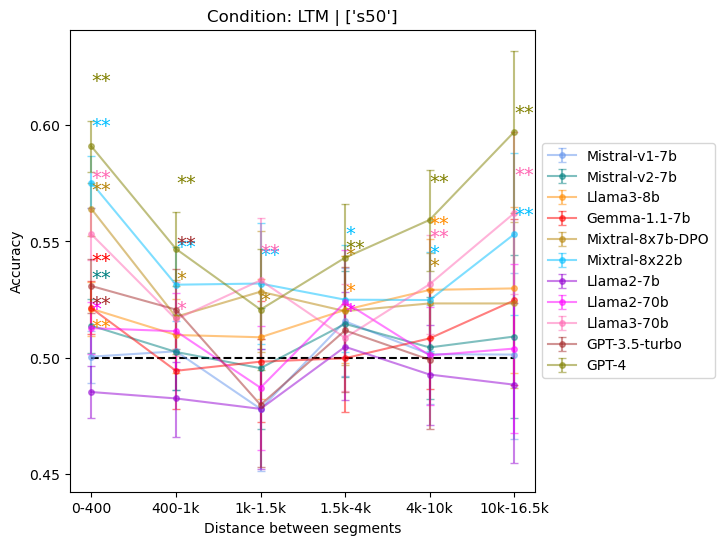

In [60]:
condition = "LTM" # "LTM-humans"
base_dir = "../"
if condition == "LTM-humans":
    download_dir = os.path.join(base_dir,"results/human-LTM")
    bins = [0,400,1000,1500,4000,10000,16500,25000,40000]
    bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k','16.5k-25k','25k-40k']
    data_path = os.path.join(base_dir,"data","human-LTM","human_segments_fix")
    gpt_data_path = os.path.join(base_dir,"data","human-LTM")
elif condition == "LTM":
    download_dir=os.path.join(base_dir,"results","LTM")
    bins = [0,400,1000,1500,4000,10000,16500]
    bin_strings = ['0-400','400-1k','1k-1.5k','1.5k-4k','4k-10k','10k-16.5k']
    data_path = os.path.join(base_dir,"data","pgbooks_data_neurips")
plot_feature = 'bin_human' # use "bin_human" for the bin_strings above (eg for LTM figure). Use "distance_bin" for LTM_human equal artificial bins

LTM = True if "ltm" in condition.lower() else False


segment_lengths = ["s50"] # "s20" "s50"

# results data
model_names_to_paths = {"mistral-instruct-7b": {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"mistral_v1_7b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"mistral-v1-7b-human-LTM"),
                                          "label": "Mistral-v1-7b",
                                          "color": "blue"},
                        "mistral-instruct-7b-v2": {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"mistral_v2_7b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"mistral-v2-7b-human-LTM"),
                                          "label": "Mistral-v2-7b",
                                          "color": "teal"},
                        "llama3-8b-instruct":  {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"llama3_8b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans":os.path.join(download_dir,"llama3-8b-human-LTM"),
                                          "label":  "Llama3-8b",
                                          "color": "gold"},
                        "gemma7b_1.1_inst": {"prompt_sweep": "None",
                                          "LTM": os.path.join(download_dir,"gemma1_1_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"gemma-1.1-7b-human-LTM"),
                                          "label": "Gemma-1.1-7b",
                                          "color": "red"},
                        "Nous-Hermes-2-Mixtral-8x7B-DPO": {"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"Mixtral-8x7b-LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"mixtral-8x7b-DPO-human-LTM"),
                                          "label": "Mixtral-8x7b-DPO",
                                          "color": "green"},
                        "Mixtral-8x22b": {"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"mix-8x22_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": None,
                                          "label": "Mixtral-8x22b",
                                          "color": "aqua"},
                        "llama2_7b-instruct":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"llama2_7b_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"llama2-7b-human-LTM"),
                                          "label": "Llama2-7b",
                                          "color": "darkviolet"
                        },
                        "llama2_70b-instruct":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"llama2-70b-LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"llama2-70b-human-LTM"),
                                          "label": "Llama2-70b",
                                          "color": "magenta"}, 
                        "llama3_70b-instruct":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"llama3-70b-LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"llama3-70b-human-LTM"),
                                          "label": "Llama3-70b",
                                          "color": "pink"},               
                        "gpt3-5":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"gpt3-5_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"gpt3-5-human-LTM"),
                                          "label": "GPT-3.5-turbo",
                                          "color": "brown"},
                        "gpt4":{"prompt_sweep": None,
                                          "LTM": os.path.join(download_dir,"gpt4_LTM"),
                                          "STM": None,
                                          "STM-humans": None,
                                          "LTM-humans": os.path.join(download_dir,"gpt4-human-LTM"),
                                          "label": "GPT-4",
                                          "color": "olive"},
}
# Analysis to run


model_names = model_names_to_paths.keys()
colors = [models_plot_info[m]["color"] for m in model_names]
model_paths = [model_names_to_paths[m][condition] for m in model_names]
model_dfs = {}

plt.figure(figsize=(6, 6))
#all_bin_edges = {}
existing_models = []
for i,(color, model_path, model_name) in enumerate(zip(colors,model_paths, model_names)):
    if model_path is None:
        continue
    path = os.path.join(model_path, "results")
    if not os.path.exists(path):
        continue
    files = [os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and any(s in f for s in segment_lengths)]
    if len(files)==0:
        continue

    dfs = []
    for file in files:
        df = pd.read_csv(file) 
        if 'human' in condition and 'gpt' in model_name.lower():
            # add the segments and excerpts to the dataframe 
            stem = df['data'].unique()[0][:-4]
            excerpts = pd.read_csv(os.path.join(gpt_data_path,f"excerpts_{stem}_filtered.csv"),index_col=0)           
            segments = pd.read_csv(os.path.join(gpt_data_path,f"segments_{stem}_filtered.csv"),index_col=0)
        else:
            # add the segments and excerpts to the dataframe (maybe needs debugging!)
            excerpts = pd.read_csv(f"{data_path}/excerpts_{df['data'].unique()[0]}",index_col=0)
            segments = pd.read_csv(f"{data_path}/segments_{df['data'].unique()[0]}",index_col=0)
        df = df.merge(excerpts,on=["book_idx","excerpt_idx"])
        if condition == "LTM-humans":
            df = df.merge(segments, on=["book_idx","excerpt_idx"])
        else:
            df = df.merge(segments, on=["book_idx","excerpt_idx", "distance_bin"])

        if condition == 'LTM-humans':
            df = apply_all(df, download_dir, LTM=LTM,human= True,segment_lengths = segment_lengths)
        else:
            df = apply_all(df, download_dir, LTM=LTM)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    #all_bin_edges[model_name] = bin_edges
    significant_features = {}
    counts = {}
    low_CI = {}
    high_CI = {}
    acc = {}
        
    for feature_val in df[plot_feature].unique().tolist()[::-1]:
        subset = df[df[plot_feature] == feature_val]
        incorrects = len(subset) - sum(subset["correct"])
        corrects = sum(subset["correct"])
        acc[feature_val] = corrects/len(subset)
        counts[feature_val] = [corrects, incorrects]
        binom_test = scipy.stats.binomtest(corrects, n=len(subset), p=0.5,alternative = 'greater')
        if binom_test.pvalue<=0.01:
            significant="**"
        elif binom_test.pvalue<=0.05:
            significant="*"
        else:
            #print(model_name, binom_test.pvalue)
            significant = ""
        significant_features[feature_val] = significant
        data = (subset['correct'],) # samples must be in a sequence
        res = bootstrap(data, np.mean, confidence_level=0.95,
                        random_state=43)
        low_CI[feature_val] = res.confidence_interval[0]
        high_CI[feature_val] = res.confidence_interval[1]
    error_arr = np.array([[acc[f]-low_CI[f],high_CI[f]-acc[f]] for f in np.unique(df[plot_feature])]).T
    acc_keys = list(acc.keys())
    acc_keys.sort()
    acc_arr = np.array([acc[f] for f in acc_keys])
    df.groupby(plot_feature)["correct"].mean().plot(color=color, marker=".", markersize=8,yerr = error_arr,capsize = 3,alpha = 0.5)
    # Add asterisks
    for feature_val in df[plot_feature].unique().tolist()[::-1]:
        x = feature_val
        y = sum(df[df[plot_feature] ==feature_val]["correct"])/len(df[df[plot_feature] == feature_val])
        plt.text(x, y + 0.01+np.random.randint(-5,5)/250, significant_features[feature_val], fontsize=14, color=color)  # Adjust offset as needed
    #plt.text(x,y+0.06, labels[0], fontsize=16, color="black")
    #plt.ylim((0.45,0.7))
    plt.title(f"Condition: {condition} | {segment_lengths}")
    existing_models.append(model_name)
    model_dfs[model_name] = df
    # Storing the data for the plot
    plot_data[model_name] = {
        'color': color, 
        'err': error_arr,
        'acc': acc_arr,
        'df': df,
        'significant_features': significant_features,
    }
plt.yticks(ticks = [0.4,0.45,0.5,0.55,0.6,0.65,0.7])

labels = [model_names_to_paths[m]["label"] for m in existing_models]

plt.legend(labels,loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines(y=0.5, xmin=min(df[plot_feature].unique().tolist()), xmax=max(df[plot_feature].unique().tolist()), linestyles="--", color="black")

#plt.xlabel(plot_feature.replace("_"," "))
if 'human' not in condition:
    plt.xticks(ticks = np.arange(len(bin_strings)),labels = bin_strings)
    plt.xlabel('Distance between segments')
else:
    plt.xticks(ticks = np.unique(df[plot_feature]),labels = np.unique(df[plot_feature]))
    plt.xlabel('Distance bins')
    #plt.xscale('log')

plt.ylabel("Accuracy")


#plt.savefig(f"condition_{condition}_{plot_feature}_{segment_lengths}.pdf", bbox_inches='tight')


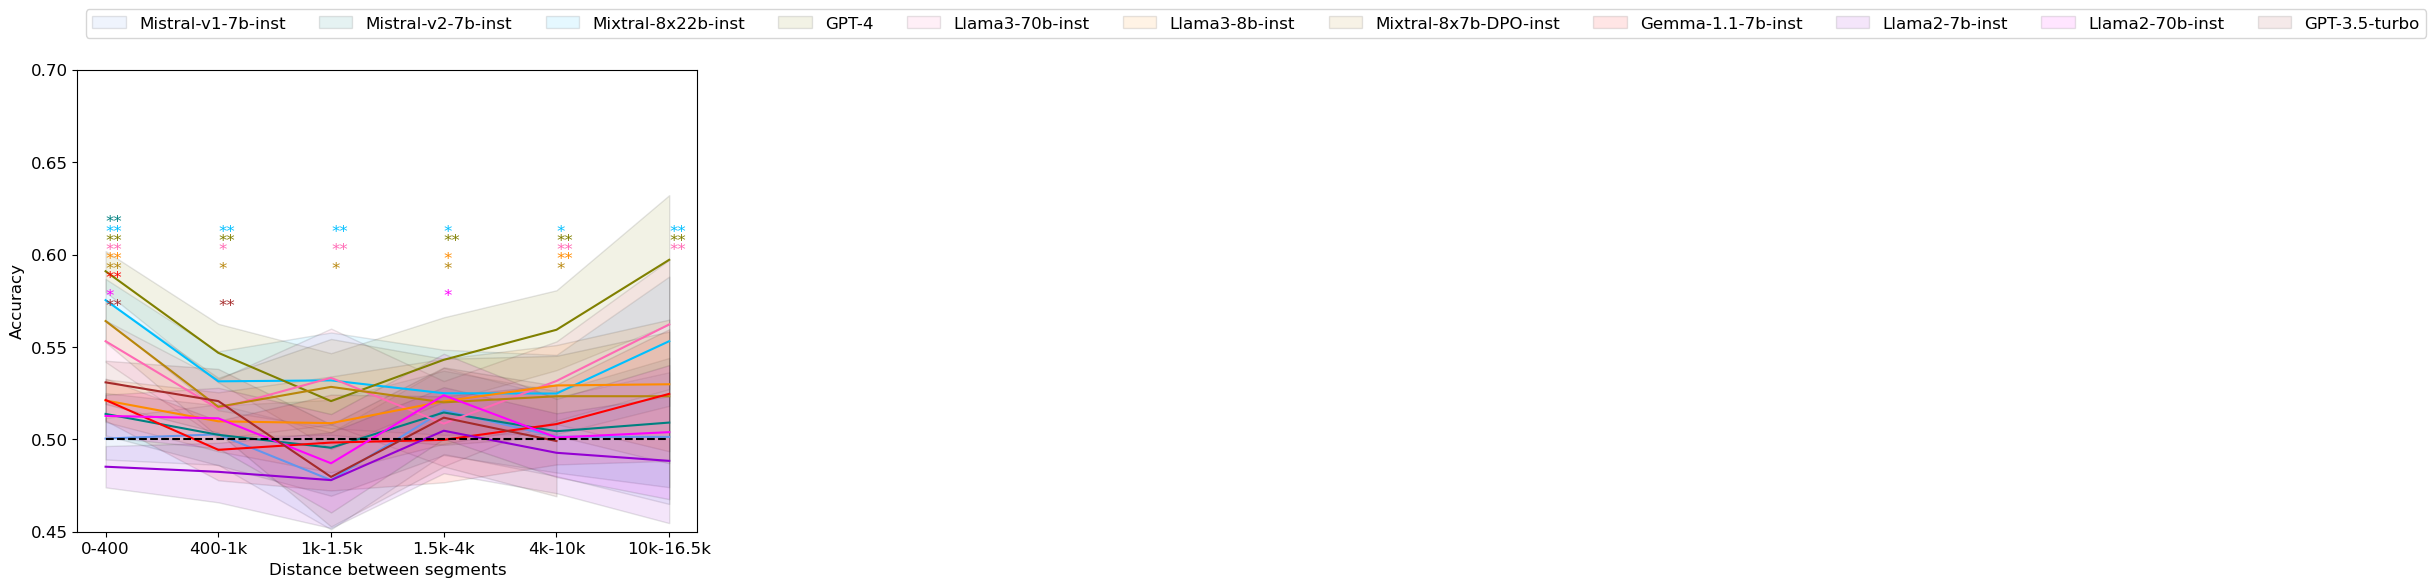

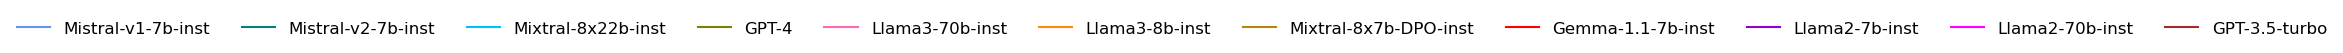

In [61]:
# fig = plt.figure(figsize=figuresize)
fig, ax = plt.subplots(figsize = (8,6))
if condition =="LTM-humans":
    y_limits = ((0,1))
    y_star = 0.9
elif condition =="LTM":
    y_limits = ((0.45,0.7))
    y_star = 0.62
labels = [models_plot_info[m]["label"] for m in models_to_plot]

if include_error_area:
    for model in models_to_plot:
        acc_arr = plot_data[model]['acc']
        error_arr = plot_data[model]['err']
        color = plot_data[model]['color']
        plt.fill_between(np.arange(len(acc_arr)), acc_arr+error_arr[1], acc_arr-error_arr[0], color=color, alpha=0.1, edgecolor='k')

for i, model in enumerate(models_to_plot):
    acc_arr = plot_data[model]['acc']
    error_arr = plot_data[model]['err']
    color = plot_data[model]['color']
    if include_error_area:
        plt.plot(acc_arr, color=color, label=model_names_to_paths[model]["label"])
    else:
        plt.errorbar(np.arange(len(acc_arr))+i*0.02,acc_arr, yerr=error_arr, color=color, label=model_names_to_paths[model]["label"], 
                     elinewidth=1, capsize=2)


for i, model in enumerate(models_to_plot):
    acc_arr = plot_data[model]['acc']
    features = list(plot_data[model]['significant_features'].keys())
    features.sort()
    significant = [plot_data[model]['significant_features'][f] for f in features]
    color = plot_data[model]['color']
    # print(significant, plot_data[model]['significant_features'])
    for feature in features:
        plt.text(feature, y_star-i*0.005, significant[feature], color=color, fontsize=fontsize)


plt.ylim(y_limits)
plt.yticks(fontsize=fontsize)

# plt.yticks(ticks = [0.4,0.45,0.5,0.55,0.6,0.65,0.7], fontsize=fontsize)

plt.hlines(y=0.5, xmin=min(df[plot_feature].unique().tolist()), xmax=max(df[plot_feature].unique().tolist()), linestyles="--", color="black")

#plt.xlabel(plot_feature.replace("_"," "))
plt.xticks(ticks = np.arange(len(bin_strings)),labels = bin_strings, fontsize=fontsize)
plt.xlabel('Distance between segments', fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)


plt.savefig(f"condition_{condition}_{plot_feature}_{segment_lengths}.pdf", bbox_inches='tight')

legend = plt.legend(labels,loc='center left', bbox_to_anchor=(0, 1.1), fontsize=fontsize, ncol=ncol_legend)
#plt.show()


#The following code extracts the legend and generates a separate file.
fig.canvas.draw()
legend_bbox = legend.get_tightbbox(fig.canvas.get_renderer())
legend_bbox = legend_bbox.transformed(fig.dpi_scale_trans.inverted())
legend_fig, legend_ax = plt.subplots(figsize=(legend_bbox.width, legend_bbox.height))
legend_squared = legend_ax.legend(
    ax.get_legend_handles_labels()[0], 
    labels,
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=legend_fig.transFigure,
    frameon=False,
    fancybox=None,
    fontsize=fontsize,
    shadow=False,
    ncol=ncol_legend,
    mode='expand',
)

# Remove everything else from the legend's figure
legend_ax.axis('off')

# Save the legend as a separate figure
plt.savefig(f"condition_{condition}_{plot_feature}_{segment_lengths}-legend.pdf", bbox_inches='tight')

In [7]:
book_mean_dict = {}
for model in model_dfs.keys():
    df = model_dfs[model]
    print('%s %.2f'%(model,np.mean(df['correct'])))
    corrects = sum(df["correct"])
    acc = corrects/len(df)
    counts = [corrects, incorrects]
    binom_test = scipy.stats.binomtest(corrects, n=len(df), p=0.5,alternative = 'greater')
    print('p-val',binom_test.pvalue)
    if binom_test.pvalue<=0.01:
        significant="**"
    elif binom_test.pvalue<=0.05:
        significant="*"
    else:
        #print(model_name, binom_test.pvalue)
        significant = ""
    print(significant)
    
    data = (df["correct"],) # samples must be in a sequence
    res = bootstrap(data, np.mean, confidence_level=0.95,
                    random_state=43)
    print('CI: %.2f, %.2f'%(res.confidence_interval[0],res.confidence_interval[1]))
    print('mean+-%.3f'%(res.confidence_interval[1]-np.mean(data)))
    print('----------------')
    df_book_mean = df.groupby('book_idx')['correct'].mean()
    book_mean_dict[model] = df_book_mean


mistral-instruct-7b 0.50
p-val 0.11563061598422228

CI: 0.50, 0.51
mean+-0.008
----------------
mistral-instruct-7b-v2 0.51
p-val 4.877500725252008e-05
**
CI: 0.51, 0.52
mean+-0.007
----------------
llama3-8b-instruct 0.51
p-val 0.00048041413422278477
**
CI: 0.51, 0.52
mean+-0.008
----------------
gemma7b_1.1_inst 0.51
p-val 0.0017476080638551893
**
CI: 0.50, 0.52
mean+-0.008
----------------
Nous-Hermes-2-Mixtral-8x7B-DPO 0.52
p-val 1.8390448277319218e-06
**
CI: 0.51, 0.53
mean+-0.008
----------------
Mixtral-8x22b 0.52
p-val 7.47711146181171e-07
**
CI: 0.51, 0.53
mean+-0.007
----------------
llama2_7b-instruct 0.50
p-val 0.5212831359654417

CI: 0.49, 0.51
mean+-0.008
----------------
llama2_70b-instruct 0.51
p-val 0.0032426008573132395
**
CI: 0.50, 0.52
mean+-0.007
----------------
llama3_70b-instruct 0.52
p-val 3.329869535219299e-05
**
CI: 0.51, 0.52
mean+-0.007
----------------
gpt3-5 0.52
p-val 2.9969330550841755e-05
**
CI: 0.51, 0.53
mean+-0.009
----------------
gpt4 0.53
p-val 3